In [12]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch
from torchinfo import summary

In [13]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "vehicle":
        return 1

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")
        num_objs = len(objects)
        boxes = []
        labels = []
        
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

class RadarDataset(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'val' in self.path:
            label_path = os.path.join("./"+weather+"/annotations_val/", file_label)
        elif 'test' in self.path:
            label_path = os.path.join("./"+weather+"/annotations_test/", file_label)
        else:
            label_path = os.path.join("./"+weather+"/annotations_train/", file_label)

        img = Image.open(img_path)
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

data_transform = transforms.Compose([ 
        transforms.ToTensor() 
    ])

In [14]:
def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):  # outputs=preds_adj_all, targets=annot_all

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # The number of predicted objects
        annotations = targets[sample_i]  # ground-truth
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): 
                
                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

from tqdm import tqdm

In [15]:
model = get_model_instance_segmentation(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
model.load_state_dict(torch.load('./fog_3.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [16]:
# Parameters
num_epochs = 20
lr=0.000001
optimizer = torch.optim.Adam(model.parameters(), lr)
weather = 'dataset/fog'

dataset = RadarDataset(data_transform, "./"+weather+"/images_train/")
val_dataset = RadarDataset(data_transform, "./"+weather+"/images_val/")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)

mean_epoch_loss_list = []
mean_val_epoch_loss_list = []
AP_list = []

print('----------------------train start--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    
    # Valdiation data
    for imgs, targets in val_data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        val_epoch_loss += losses.item()
    mean_val_epoch_loss = val_epoch_loss/len(val_data_loader)

    # Train data
    for imgs, targets in data_loader:
        optimizer.zero_grad()
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        losses.backward()
        optimizer.step()
    mean_epoch_loss = epoch_loss/len(data_loader)
        
    # AP Caculation
    labels = []
    preds_adj_all = []
    annot_all = []
    for im, annot in tqdm(val_data_loader, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        for t in annot:
            labels += t['labels']
        with torch.no_grad():
            preds_adj = make_prediction(model, im, 0.5)
            preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
            preds_adj_all.append(preds_adj)
            annot_all.append(annot)
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP = torch.mean(AP)
    
    AP_list.append(mAP)
    mean_epoch_loss_list.append(mean_epoch_loss) 
    mean_val_epoch_loss_list.append(mean_val_epoch_loss)
    
    torch.save(model.state_dict(), './fog_3+'+str(epoch+1)+'.pt')
    print(f'epoch : {epoch+1}, Train Loss : {mean_epoch_loss}, Val Loss : {mean_val_epoch_loss}, Time : {time.time() - start}, AP : {mAP}')

----------------------train start--------------------------


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.97it/s]


epoch : 1, Train Loss : 0.08096380997893705, Val Loss : 0.13814467693177554, Time : 127.39988017082214, AP : 0.9497747691868614


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.94it/s]


epoch : 2, Train Loss : 0.07289332105180245, Val Loss : 0.11121416770709822, Time : 127.85465574264526, AP : 0.9517339992022933


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.90it/s]


epoch : 3, Train Loss : 0.06964712877822306, Val Loss : 0.1082761855616879, Time : 128.48368763923645, AP : 0.9565781569634062


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.92it/s]


epoch : 4, Train Loss : 0.0671506924510251, Val Loss : 0.10632840264588594, Time : 128.76885890960693, AP : 0.9568602463320737


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.94it/s]


epoch : 5, Train Loss : 0.06486165611104493, Val Loss : 0.10727693271250106, Time : 129.02998065948486, AP : 0.9571510335912237


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 6, Train Loss : 0.06328472697569462, Val Loss : 0.10681418272165152, Time : 129.05660820007324, AP : 0.9573137340935975


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.95it/s]


epoch : 7, Train Loss : 0.0617625020991184, Val Loss : 0.10753539406981033, Time : 129.15286421775818, AP : 0.95752147008184


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.97it/s]


epoch : 8, Train Loss : 0.06010490710355857, Val Loss : 0.10849213705827984, Time : 129.29623293876648, AP : 0.9543439436511534


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.99it/s]


epoch : 9, Train Loss : 0.05906589948049878, Val Loss : 0.1089677122206642, Time : 129.04053926467896, AP : 0.9549025163051219


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 10, Train Loss : 0.05849462782470665, Val Loss : 0.1090797924150068, Time : 129.76016283035278, AP : 0.9549789968883928


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.92it/s]


epoch : 11, Train Loss : 0.05763809040837826, Val Loss : 0.10830768425232516, Time : 129.67886090278625, AP : 0.9549305873562659


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.94it/s]


epoch : 12, Train Loss : 0.055676084443002156, Val Loss : 0.11198961509105104, Time : 129.73325943946838, AP : 0.9552441969709342


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 13, Train Loss : 0.055200068989150704, Val Loss : 0.11038105834562045, Time : 129.67497563362122, AP : 0.9554132719176955


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.92it/s]


epoch : 14, Train Loss : 0.0540550200286408, Val Loss : 0.11375285149551928, Time : 129.81583833694458, AP : 0.9514787998037484


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.67it/s]


epoch : 15, Train Loss : 0.053212740247389013, Val Loss : 0.11322956371049468, Time : 129.95218086242676, AP : 0.9511439726125381


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 16, Train Loss : 0.05226268266885584, Val Loss : 0.11349182545494002, Time : 131.60754132270813, AP : 0.9511354628782769


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 17, Train Loss : 0.05179153750194926, Val Loss : 0.11486947872281934, Time : 129.33481097221375, AP : 0.9468765879267593


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.92it/s]


epoch : 18, Train Loss : 0.05090655505363796, Val Loss : 0.11834947342196336, Time : 129.30833864212036, AP : 0.9470882416265844


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.90it/s]


epoch : 19, Train Loss : 0.049978418342395727, Val Loss : 0.11669838340738072, Time : 129.36411499977112, AP : 0.9472800907234991


100%|███████████████████████████████████████████| 52/52 [00:06<00:00,  7.91it/s]


epoch : 20, Train Loss : 0.04917399340969353, Val Loss : 0.11886861578274804, Time : 130.13962388038635, AP : 0.9471665935057203


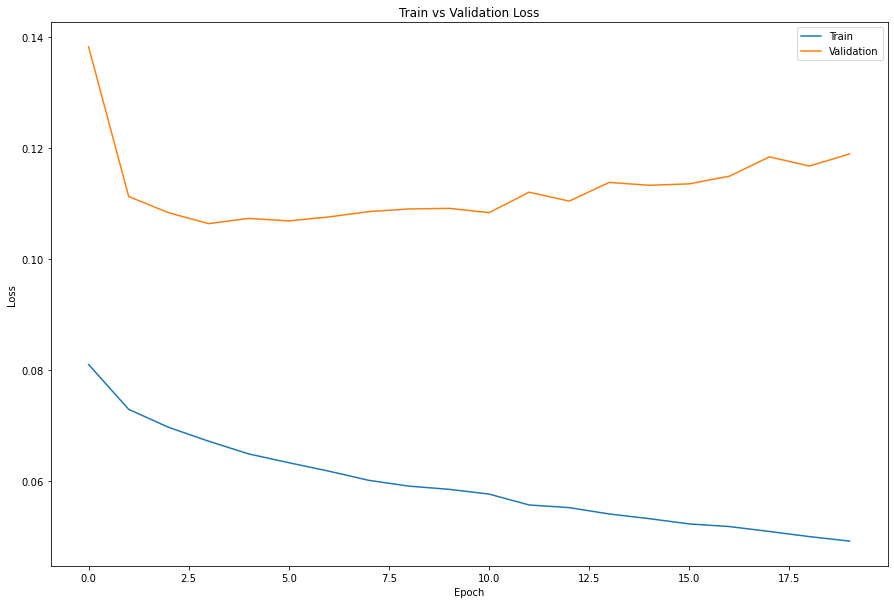

In [17]:
y1 = mean_epoch_loss_list
y2 = mean_val_epoch_loss_list
x = list(range(0,len(y1)))

plt.figure(figsize=(15,10))
plt.plot(x, y1, label = "Train")
plt.plot(x, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [18]:
model = get_model_instance_segmentation(2)
model.to(device)
model.load_state_dict(torch.load('./rain_3.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
# Parameters
num_epochs = 20
lr=0.000001
optimizer = torch.optim.Adam(model.parameters(), lr)
weather = 'dataset/rain'

dataset = RadarDataset(data_transform, "./"+weather+"/images_train/")
val_dataset = RadarDataset(data_transform, "./"+weather+"/images_val/")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)

mean_epoch_loss_list = []
mean_val_epoch_loss_list = []
AP_list = []

print('----------------------train start--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    
    # Valdiation data
    for imgs, targets in val_data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        val_epoch_loss += losses.item()
    mean_val_epoch_loss = val_epoch_loss/len(val_data_loader)

    # Train data
    for imgs, targets in data_loader:
        optimizer.zero_grad()
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        losses.backward()
        optimizer.step()
    mean_epoch_loss = epoch_loss/len(data_loader)
        
    # AP Caculation
    labels = []
    preds_adj_all = []
    annot_all = []
    for im, annot in tqdm(val_data_loader, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        for t in annot:
            labels += t['labels']
        with torch.no_grad():
            preds_adj = make_prediction(model, im, 0.5)
            preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
            preds_adj_all.append(preds_adj)
            annot_all.append(annot)
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP = torch.mean(AP)
    
    AP_list.append(mAP)
    mean_epoch_loss_list.append(mean_epoch_loss) 
    mean_val_epoch_loss_list.append(mean_val_epoch_loss)
    
    torch.save(model.state_dict(), './rain_3+'+str(epoch+1)+'.pt')
    print(f'epoch : {epoch+1}, Train Loss : {mean_epoch_loss}, Val Loss : {mean_val_epoch_loss}, Time : {time.time() - start}, AP : {mAP}')

----------------------train start--------------------------


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.96it/s]


epoch : 1, Train Loss : 0.249945895006236, Val Loss : 0.32126047830097376, Time : 395.29583954811096, AP : 0.8818952755831582


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.95it/s]


epoch : 2, Train Loss : 0.23693725987861716, Val Loss : 0.3011861746199429, Time : 394.3744351863861, AP : 0.8842416039758003


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.01it/s]


epoch : 3, Train Loss : 0.22965213760245043, Val Loss : 0.29885276255663484, Time : 395.1263360977173, AP : 0.8862944106185893


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.02it/s]


epoch : 4, Train Loss : 0.22426362973430675, Val Loss : 0.2984047139296308, Time : 394.0102126598358, AP : 0.8845237334159695


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.05it/s]


epoch : 5, Train Loss : 0.2197647321559227, Val Loss : 0.2990887945750728, Time : 393.84589314460754, AP : 0.8871053147486041


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.05it/s]


epoch : 6, Train Loss : 0.21537378868618856, Val Loss : 0.2973341110395268, Time : 393.85509729385376, AP : 0.8913643007354359


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.02it/s]


epoch : 7, Train Loss : 0.21184903250063516, Val Loss : 0.29248144109733404, Time : 393.80401968955994, AP : 0.8907987508816877


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.04it/s]


epoch : 8, Train Loss : 0.20895821053118888, Val Loss : 0.29449126340914517, Time : 393.8329026699066, AP : 0.8913508270115802


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.04it/s]


epoch : 9, Train Loss : 0.2056332344449562, Val Loss : 0.29468462518416344, Time : 393.7991683483124, AP : 0.8912644484778447


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.98it/s]


epoch : 10, Train Loss : 0.2015233637007487, Val Loss : 0.29697063073981556, Time : 394.35878705978394, AP : 0.892033524007342


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.97it/s]


epoch : 11, Train Loss : 0.19887965113494566, Val Loss : 0.29731280251871794, Time : 393.91214323043823, AP : 0.8902196197185273


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.98it/s]


epoch : 12, Train Loss : 0.19657795583999407, Val Loss : 0.2982325556920841, Time : 394.2836346626282, AP : 0.8940706474334572


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.98it/s]


epoch : 13, Train Loss : 0.19343901496121746, Val Loss : 0.29785583522170783, Time : 394.2714886665344, AP : 0.8917725250964796


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.98it/s]


epoch : 14, Train Loss : 0.1908811743063656, Val Loss : 0.30177689937409014, Time : 394.3161053657532, AP : 0.8934728460891019


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.96it/s]


epoch : 15, Train Loss : 0.1883757473896552, Val Loss : 0.3022923953132704, Time : 394.56304693222046, AP : 0.8929223867551386


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.97it/s]


epoch : 16, Train Loss : 0.18568789517648002, Val Loss : 0.302938706218265, Time : 394.4214057922363, AP : 0.8915831877457805


100%|█████████████████████████████████████████| 160/160 [00:20<00:00,  7.99it/s]


epoch : 17, Train Loss : 0.183002344164692, Val Loss : 0.3039352870779112, Time : 394.1577351093292, AP : 0.8926040519297196


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.03it/s]


epoch : 18, Train Loss : 0.18118609183821988, Val Loss : 0.3038639946607873, Time : 394.3139023780823, AP : 0.8910865216203483


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.03it/s]


epoch : 19, Train Loss : 0.17892144487372466, Val Loss : 0.304549141228199, Time : 394.1101167201996, AP : 0.8915794443163776


100%|█████████████████████████████████████████| 160/160 [00:19<00:00,  8.04it/s]


epoch : 20, Train Loss : 0.1764183953916254, Val Loss : 0.3037316631525755, Time : 394.1296212673187, AP : 0.8903178280610202


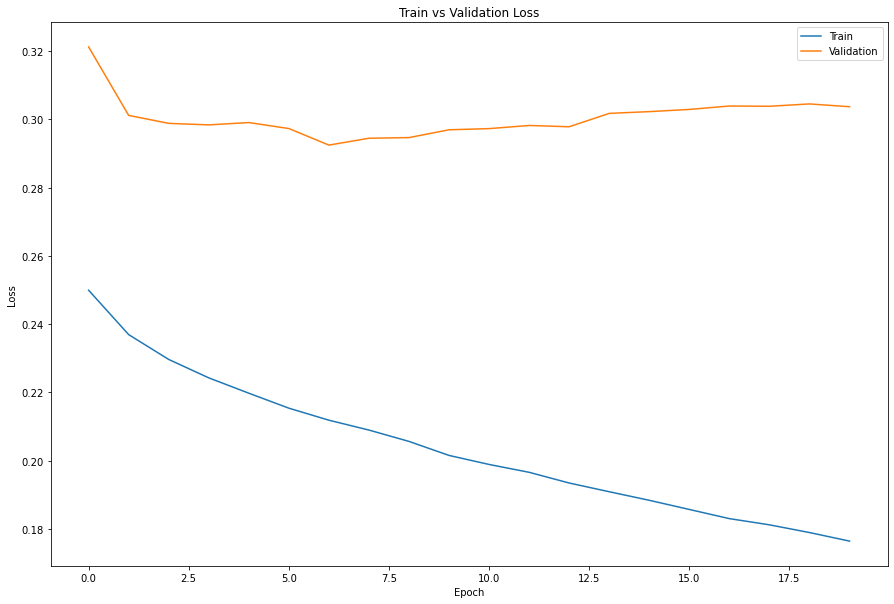

In [20]:
y1 = mean_epoch_loss_list
y2 = mean_val_epoch_loss_list
x = list(range(0,len(y1)))

plt.figure(figsize=(15,10))
plt.plot(x, y1, label = "Train")
plt.plot(x, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [21]:
model = get_model_instance_segmentation(2)
model.to(device)
model.load_state_dict(torch.load('./sunny_3.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
# Parameters
num_epochs = 20
lr=0.000001
optimizer = torch.optim.Adam(model.parameters(), lr)
weather = 'dataset/sunny'

dataset = RadarDataset(data_transform, "./"+weather+"/images_train/")
val_dataset = RadarDataset(data_transform, "./"+weather+"/images_val/")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)

mean_epoch_loss_list = []
mean_val_epoch_loss_list = []
AP_list = []

print('----------------------train start--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    
    # Valdiation data
    for imgs, targets in val_data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        val_epoch_loss += losses.item()
    mean_val_epoch_loss = val_epoch_loss/len(val_data_loader)

    # Train data
    for imgs, targets in data_loader:
        optimizer.zero_grad()
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        losses.backward()
        optimizer.step()
    mean_epoch_loss = epoch_loss/len(data_loader)
        
    # AP Caculation
    labels = []
    preds_adj_all = []
    annot_all = []
    for im, annot in tqdm(val_data_loader, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        for t in annot:
            labels += t['labels']
        with torch.no_grad():
            preds_adj = make_prediction(model, im, 0.5)
            preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
            preds_adj_all.append(preds_adj)
            annot_all.append(annot)
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP = torch.mean(AP)
    
    AP_list.append(mAP)
    mean_epoch_loss_list.append(mean_epoch_loss) 
    mean_val_epoch_loss_list.append(mean_val_epoch_loss)
    
    torch.save(model.state_dict(), './sunny_3+'+str(epoch+1)+'.pt')
    print(f'epoch : {epoch+1}, Train Loss : {mean_epoch_loss}, Val Loss : {mean_val_epoch_loss}, Time : {time.time() - start}, AP : {mAP}')

----------------------train start--------------------------


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.07it/s]


epoch : 1, Train Loss : 0.07294150012727808, Val Loss : 0.09343626986463997, Time : 367.3802411556244, AP : 0.9515358277462624


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.06it/s]


epoch : 2, Train Loss : 0.06870488127166252, Val Loss : 0.08545399050934603, Time : 367.70557618141174, AP : 0.9563746397107273


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.08it/s]


epoch : 3, Train Loss : 0.06700440944473522, Val Loss : 0.08475517932850643, Time : 368.4110760688782, AP : 0.9548793895264858


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.08it/s]


epoch : 4, Train Loss : 0.06618181128566539, Val Loss : 0.08314227502818075, Time : 367.9763436317444, AP : 0.960791848859877


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.07it/s]


epoch : 5, Train Loss : 0.0650437853565842, Val Loss : 0.082304995932035, Time : 367.8809132575989, AP : 0.9579502731421954


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.00it/s]


epoch : 6, Train Loss : 0.06402523001699616, Val Loss : 0.08346075942152298, Time : 372.3112761974335, AP : 0.9636041283726371


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  7.99it/s]


epoch : 7, Train Loss : 0.0636081409919851, Val Loss : 0.08376805285529403, Time : 368.4589443206787, AP : 0.963666592318571


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.00it/s]


epoch : 8, Train Loss : 0.06291418102331198, Val Loss : 0.08392297731549948, Time : 368.68587374687195, AP : 0.9639316866656955


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.07it/s]


epoch : 9, Train Loss : 0.062102658033739135, Val Loss : 0.08474047539518184, Time : 368.29587721824646, AP : 0.9641529561830318


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.09it/s]


epoch : 10, Train Loss : 0.061805695031693135, Val Loss : 0.08521270699449034, Time : 367.4410352706909, AP : 0.9623819480641806


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.07it/s]


epoch : 11, Train Loss : 0.06126255250553066, Val Loss : 0.08541044485348984, Time : 367.32705783843994, AP : 0.9623067759208297


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.09it/s]


epoch : 12, Train Loss : 0.06070426858375021, Val Loss : 0.08606000273369703, Time : 367.2179160118103, AP : 0.9645599706002841


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.04it/s]


epoch : 13, Train Loss : 0.0598814445337159, Val Loss : 0.08647789746122872, Time : 367.73300862312317, AP : 0.9624676031662034


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.00it/s]


epoch : 14, Train Loss : 0.05928303104539837, Val Loss : 0.08702569698052318, Time : 368.12925815582275, AP : 0.9668587656935195


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.00it/s]


epoch : 15, Train Loss : 0.058905391391504, Val Loss : 0.0869765344619651, Time : 368.52431774139404, AP : 0.9647145332878537


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.01it/s]


epoch : 16, Train Loss : 0.05876400570386718, Val Loss : 0.08596108666302374, Time : 368.64945340156555, AP : 0.9627287479124824


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.07it/s]


epoch : 17, Train Loss : 0.05836530820851899, Val Loss : 0.08781065310557816, Time : 368.773113489151, AP : 0.9649518957811907


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.08it/s]


epoch : 18, Train Loss : 0.05788240398528363, Val Loss : 0.08670774489741197, Time : 368.2285227775574, AP : 0.9628922197767764


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.09it/s]


epoch : 19, Train Loss : 0.05745952138505639, Val Loss : 0.08836211113496714, Time : 368.2497205734253, AP : 0.9629961170681867


100%|█████████████████████████████████████████| 149/149 [00:18<00:00,  8.06it/s]


epoch : 20, Train Loss : 0.0569845276301293, Val Loss : 0.0891255498019941, Time : 368.2968945503235, AP : 0.9628012899962357


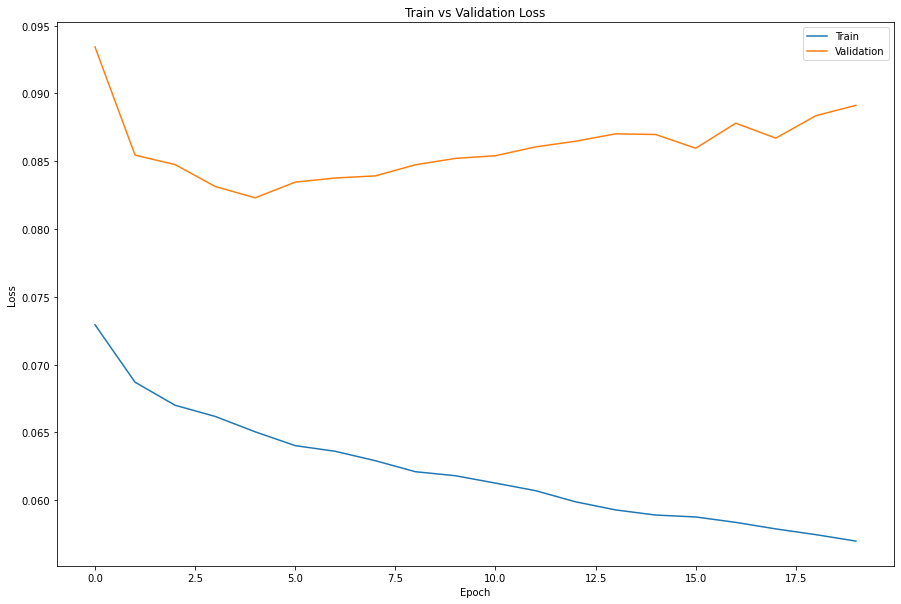

In [23]:
y1 = mean_epoch_loss_list
y2 = mean_val_epoch_loss_list
x = list(range(0,len(y1)))

plt.figure(figsize=(15,10))
plt.plot(x, y1, label = "Train")
plt.plot(x, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()